In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ovrlpy

import sys
sys.path.extend(['../../scripts','../../scripts/xenium'])
import readwrite
cfg = readwrite.config()

## Load data

In [2]:
# cfg paths
xenium_dir = Path(cfg['xenium_processed_data_dir'])
xenium_raw_data_dir = Path(cfg['xenium_raw_data_dir'])
results_dir = Path(cfg['results_dir'])

# Segmentation, mapping paths
dir_segmentations = {
    dir_segmentation.name: (dir_segmentation)
    for dir_segmentation in xenium_dir.iterdir()
}

# Read resegmentations and RCTD
xenium_paths = {}
cc_paths = []

for segmentation in (segmentations := xenium_dir.iterdir()):
    for cohort in (cohorts := segmentation.iterdir()): 
        for panel in (panels := cohort.iterdir()):
            for sample in (samples := panel.iterdir()):
                for replicate in (replicates := sample.iterdir()):
                    
                    k = (segmentation.stem,cohort.stem,panel.stem,sample.stem,replicate.stem)
                    replicate_path = replicate / "normalised_results/outs"
                    name = '/'.join(k)

                    xenium_paths[k] = replicate_path

xenium_paths = {list(xenium_paths)[30]:xenium_paths[list(xenium_paths)[30]]}

xenium_levels = ('segmentation','cohort','panel','sample','replicate')
sds = readwrite.read_xenium_samples(xenium_paths,anndata_only=False,transcripts=True,sample_name_as_key=False)
sds = pd.Series(sds.values(),
                index=pd.Index(sds.keys(),name = xenium_levels),
                dtype=object).sort_index()

Exception ignored in: <function _releaseLock at 0x7feb219c8ae0>
Traceback (most recent call last):
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/logging/__init__.py", line 237, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
w

Error processing [Errno 2] No such file or directory: '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/segger/NSCLC/chuvio/0PSV/0PSV_2/normalised_results/outs/experiment.xenium'


Running vertical adjustment
Creating gene expression embeddings for visualization:
Analyzing in 3d mode:
determining pseudocells:
found 11537 pseudocells
sampling expression:


VWF: 100%|██████████| 280/280 [03:03<00:00,  1.52it/s]     


Modeling 20 pseudo-celltype clusters;


/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Creating signal integrity map:


100%|██████████| 35/35 [01:48<00:00,  3.10s/it]
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


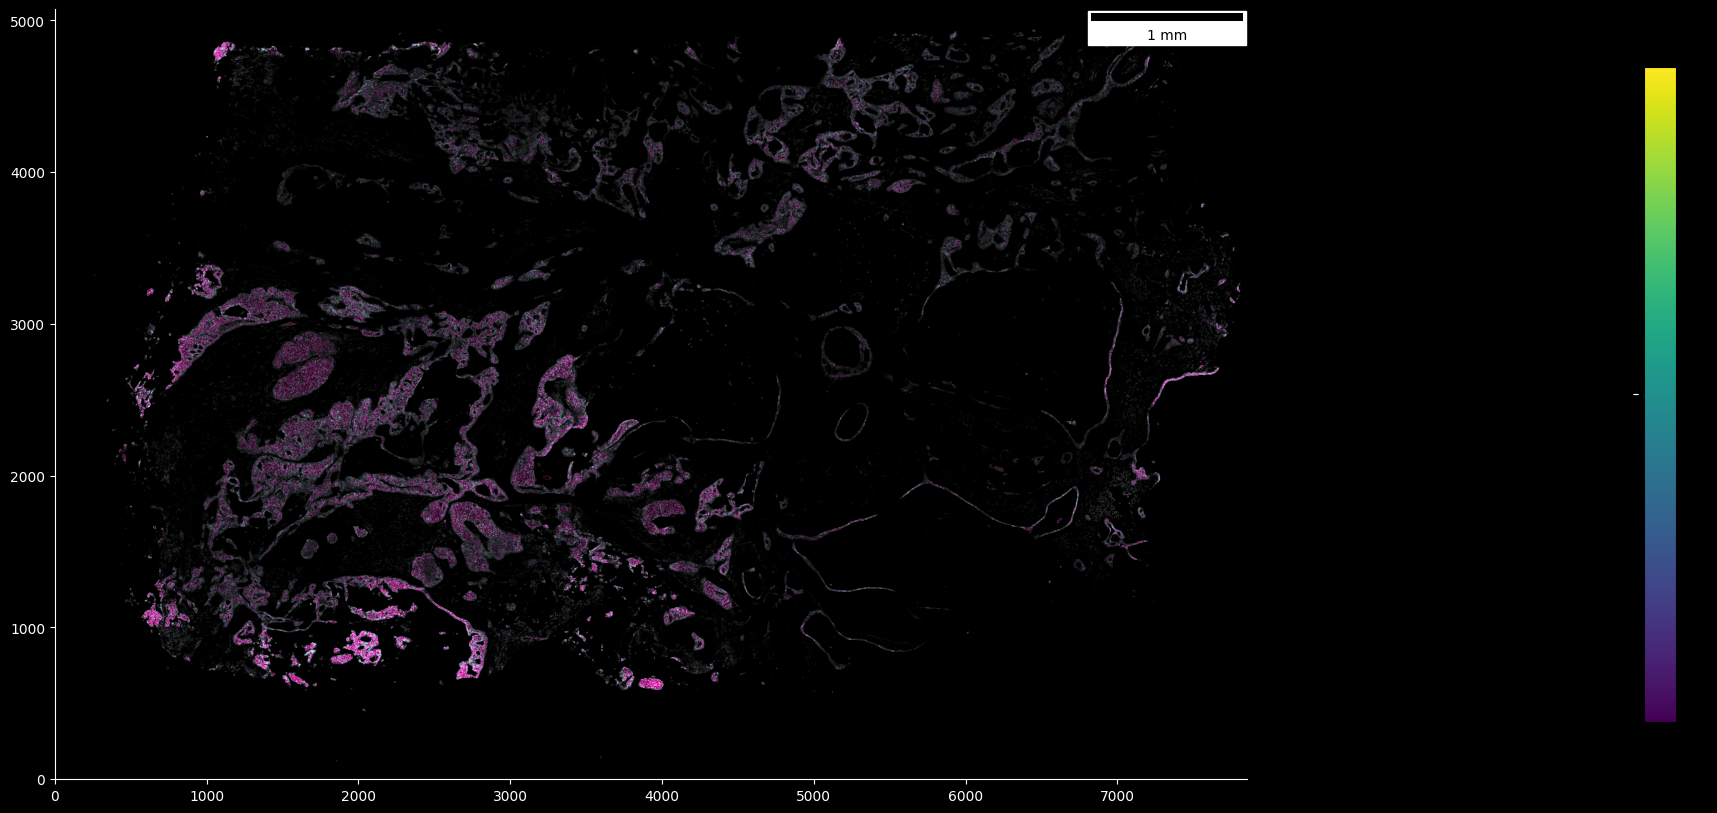

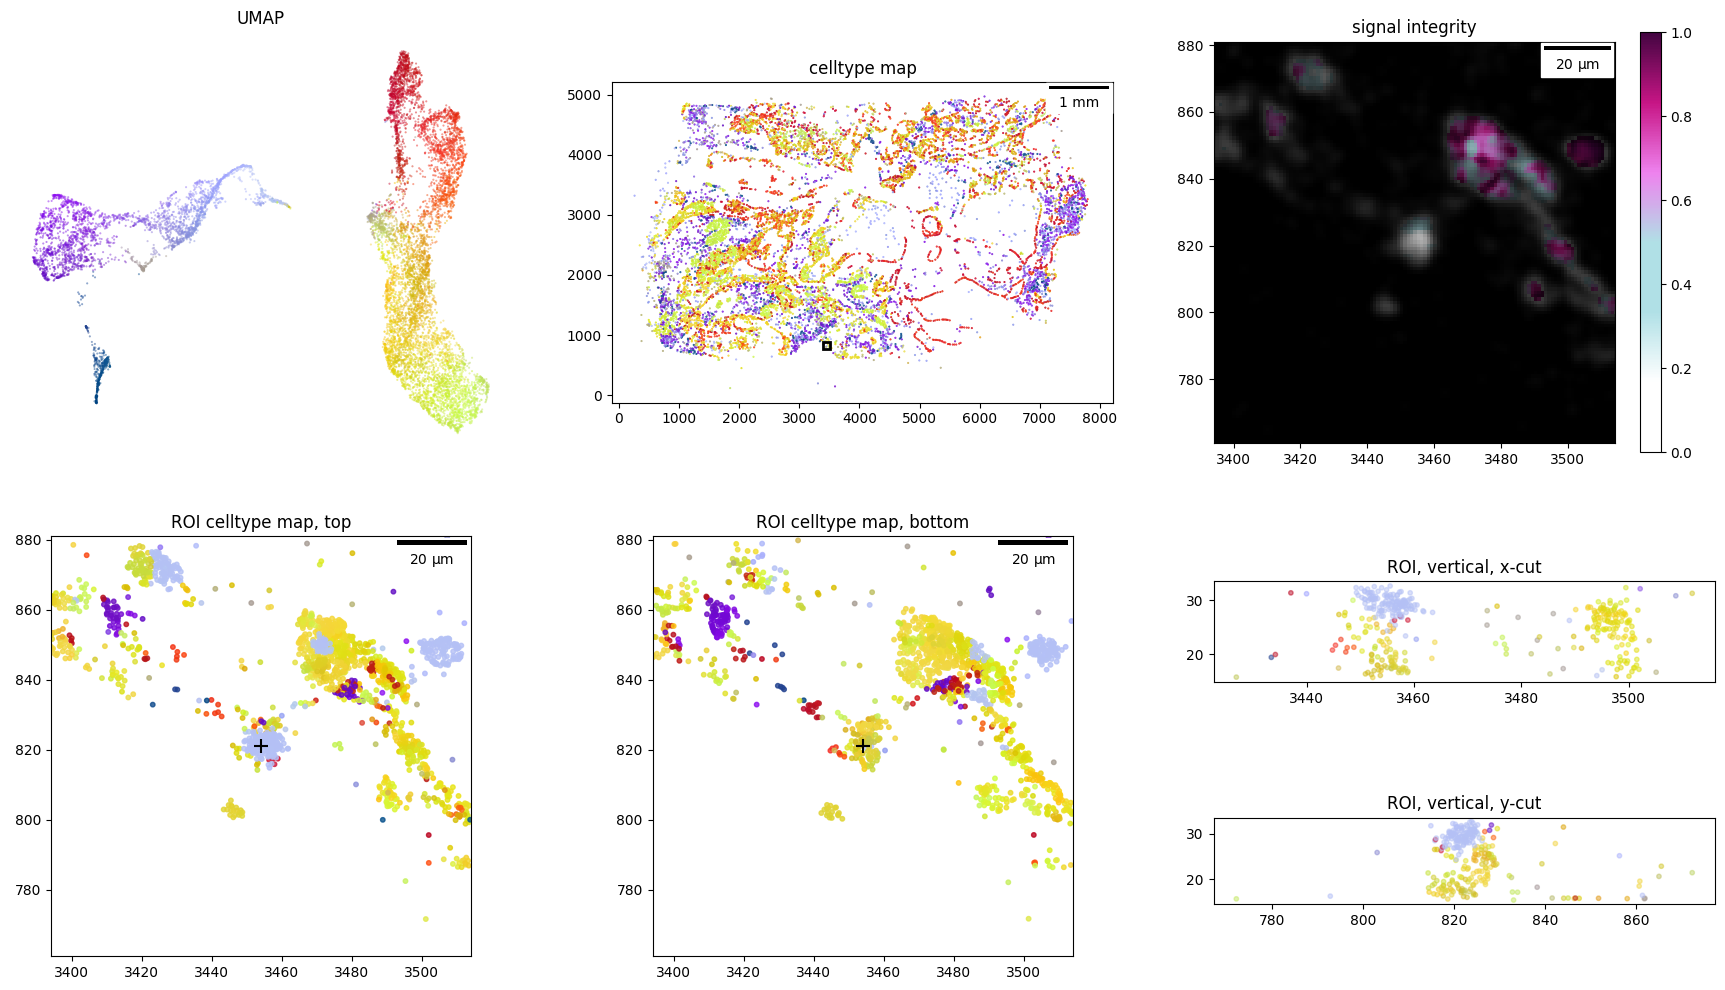

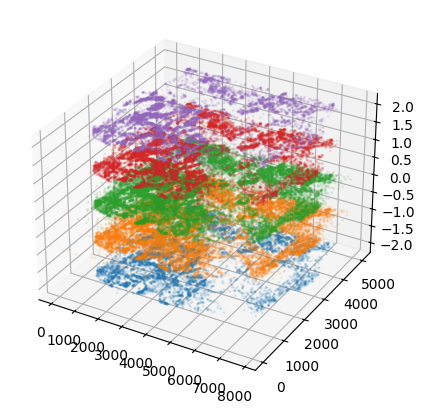

In [2]:
path = Path('/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/processed/segmentation/10x_0um/breast/breast/1256/1256/normalised_results/outs/transcripts.parquet')
coordinate_df = pd.read_parquet(path).query("is_gene & (qv >= 20)") \
    .rename(
        columns={
            "x_location": "x",
            "y_location": "y",
            "z_location": "z",
            "feature_name": "gene",
        }) \
    .query("is_gene & (qv >= 20)")  # remove dummy molecules

coordinate_df["gene"] = coordinate_df["gene"].astype("category")

# coordinate_df[::1000].plot.scatter(x="x", y="y", s=1)
# coordinate_df = coordinate_df.copy()  # make a copy to avoid SettingWithCopyWarning

signal_integrity, signal_strength, visualizer = ovrlpy.run(
    df=coordinate_df, cell_diameter=10, n_expected_celltypes=20
)

fig, ax = ovrlpy.plot_signal_integrity(
    signal_integrity, signal_strength, signal_threshold=3
)

doublet_df = ovrlpy.detect_doublets(
    signal_integrity, signal_strength, minimum_signal_strength=3, integrity_sigma=2
)

_ = plt.scatter(
    doublet_df["x"],
    doublet_df["y"],
    c=doublet_df["integrity"],
    s=1,
    cmap="viridis",
    vmin=0,
    vmax=1,
)
plt.gca().set_aspect("equal")
plt.colorbar()


window_size = 60
doublet_case = 0

x, y = doublet_df.loc[doublet_case, ["x", "y"]]

ovrlpy.plot_region_of_interest(
    x,
    y,
    coordinate_df,
    visualizer,
    signal_integrity,
    signal_strength,
    window_size=window_size,
)


# visualizer.save(result_folder / "Xenium-text-visualizer.vis")

# vis = ovrlpy.load_visualizer(result_folder / "Xenium-text-visualizer.vis")

plt.figure(figsize=(20, 5))

ax = plt.subplot(111, projection="3d")

for i in range(-2, 3):
    subset = coordinate_df[(coordinate_df.z - coordinate_df.z_delim).between(i, i + 1)]

    ax.scatter(
        subset.x[::100],
        subset.y[::100],
        np.zeros(1 + (len(subset) // 100)) + i,
        s=1,
        alpha=0.1,
    )